# Spike density function(PSTH) Plotting

### Load Configs

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *
from scipy.ndimage import gaussian_filter1d
from config import dir_config, main_config
compiled_dir = Path(dir_config.data.compiled)


### Load spike data and trial information

In [3]:
session_metadata = pd.read_csv(Path(compiled_dir, "sessions_metadata.csv"), index_col=None)
session_name = '210603_GP_JP'
sorting_dir = Path(dir_config.data.sorting)
sorting_data_path = Path(sorting_dir,session_name,'kilosort4')

spike_times = np.load(sorting_data_path / "spike_times.npy")
spike_clusters = np.load(sorting_data_path / "spike_clusters.npy")
cluster_info = pd.read_csv(sorting_data_path / "cluster_info.tsv", sep='\t', index_col=False)
# sorted good clusters
good_clusters = cluster_info[cluster_info.group == 'good']

timestamps = pd.read_csv(Path(compiled_dir, session_name,f"{session_name}_timestamps.csv"), index_col=None)
trial_info = pd.read_csv(Path(compiled_dir, session_name,f"{session_name}_trial.csv"), index_col=None)
coherence_levels = np.unique(trial_info.loc[~np.isnan(trial_info['coherence']),'coherence'])



### Utils

In [4]:
# extract spikes aligned to specific event, then smoothened

def spike_train_convolved(cluster_spike_time,timestamps,valid_trial,alignment_settings,alignment_buffer):

    valid_trial_timestamps = timestamps.iloc[valid_trial]
    spike_train = []
    convolved_spike_density = []
    sigma = 10 # 10ms smoothing
    
    for alignment_idx in range(len(alignment_settings)):
        spike_train.append(np.zeros([valid_trial.shape[0], 1 + alignment_settings[alignment_idx]['end_time_ms'] - alignment_settings[alignment_idx]['start_time_ms'] + 2*alignment_buffer]))
        convolved_spike_density.append(np.zeros([valid_trial.shape[0], 1 + alignment_settings[alignment_idx]['end_time_ms'] - alignment_settings[alignment_idx]['start_time_ms'] + 2*alignment_buffer]))

        for idx, trial_id in enumerate(valid_trial):
            start_timestamp = valid_trial_timestamps.loc[trial_id,alignment_settings[alignment_idx]['alignment_event']] + (alignment_settings[alignment_idx]['start_time_ms']-alignment_buffer) * 30 
            end_timestamp = valid_trial_timestamps.loc[trial_id,alignment_settings[alignment_idx]['alignment_event']] + (alignment_settings[alignment_idx]['end_time_ms']+alignment_buffer) *30
            spikes_timestamp = cluster_spike_time[(cluster_spike_time >= start_timestamp) & (cluster_spike_time <= end_timestamp)] - start_timestamp
            spike_train[alignment_idx][idx,np.ceil(spikes_timestamp/30).astype(int)] = 1
            convolved_spike_density[alignment_idx][idx,:] = gaussian_filter1d(spike_train[alignment_idx][idx,:],sigma=sigma,truncate=3) # gaussian smoothened

            if alignment_settings[alignment_idx]['alignment_event'] == 'stimulus_onset':
                if end_timestamp > valid_trial_timestamps.loc[trial_id,'response_onset'] - 50*30:  # exclude spikes after -50ms aligned to saccade
                    pre_saccade_idx = np.ceil((end_timestamp-valid_trial_timestamps.loc[trial_id,'response_onset'] )/30 + 50).astype(int)
                    spike_train[alignment_idx][idx,-pre_saccade_idx:] = np.nan
                    convolved_spike_density[alignment_idx][idx,-pre_saccade_idx:] = np.nan

            
            # elif alignment_settings[alignment_idx]['alignment_event'] == 'response_onset':
            #     if start_timestamp < 
    
        
        spike_train[alignment_idx] = spike_train[alignment_idx][:,alignment_buffer:-alignment_buffer]
        convolved_spike_density[alignment_idx] = convolved_spike_density[alignment_idx][:,alignment_buffer:-alignment_buffer] * 1000
        

    return spike_train,convolved_spike_density

### VGS settings

In [5]:
# extract specific VGS trials: valid/correct
VGS_valid_trial_idx = np.where((trial_info['task_type'] == 2) & (trial_info['outcome'] == 1))[0]

# alignment settings for VGS trials
alignment_settings_VGS = [
    {'alignment_event': 'target_onset',
    'start_time_ms': -100,
    'end_time_ms': 300},

    {'alignment_event': 'response_onset',
    'start_time_ms': -300,
    'end_time_ms': 100}]

alignment_buffer = 50 




### GP settings

In [6]:
# extract specific VGS trials: valid
GP_valid_trial_idx = np.where((trial_info['task_type'] == 1) & (trial_info['outcome'] >= 0))[0]

# alignment settings for GP trials
alignment_settings_GP = [
    {'alignment_event': 'target_onset',
    'start_time_ms': -100,
    'end_time_ms': 300},

    {'alignment_event': 'stimulus_onset',
    'start_time_ms': -100,
    'end_time_ms': 800},

    {'alignment_event': 'response_onset',
    'start_time_ms': -300,
    'end_time_ms': 100}]

alignment_buffer = 50 




### Plot spike density functions

In [13]:
# cluster to show
cluster_to_show = cluster_info.cluster_id
# cluster_to_show = cluster_info[cluster_info.group == 'good'].cluster_id
# cluster_to_show = cluster_info[cluster_info.KSLabel == 'good'].cluster_id

##### toRF vs awayRF trials

In [31]:
type(cluster_info)

pandas.core.frame.DataFrame

In [33]:
cluster_info.loc[cluster_info['cluster_id'] == cluster_id,'ch'].item()

11

In [27]:
f"cluster {cluster_id}, channel {1+cluster_info.loc[cluster_info['cluster_id'] == cluster_id,'ch']}"

'cluster 22, channel 18    12\nName: ch, dtype: int64'

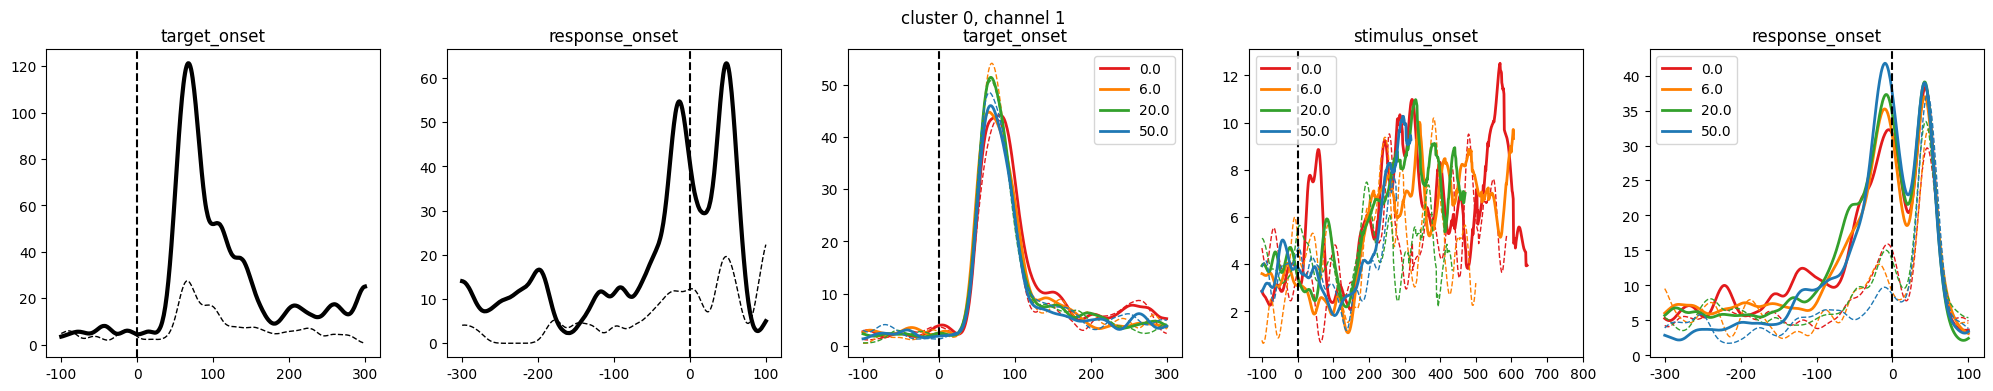

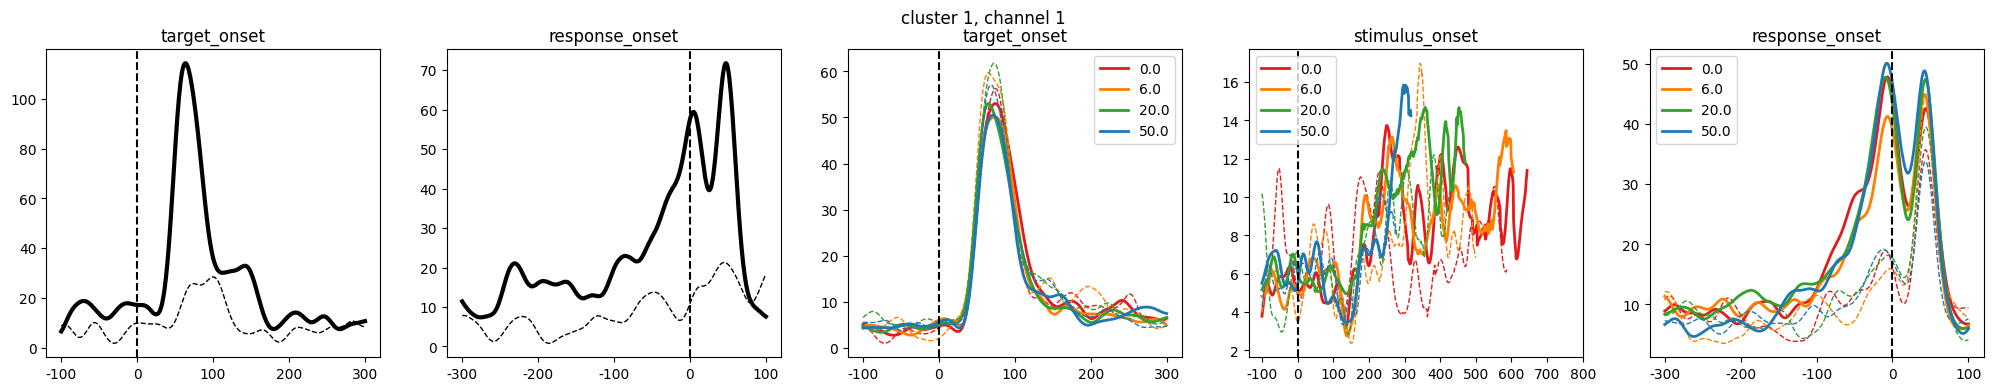

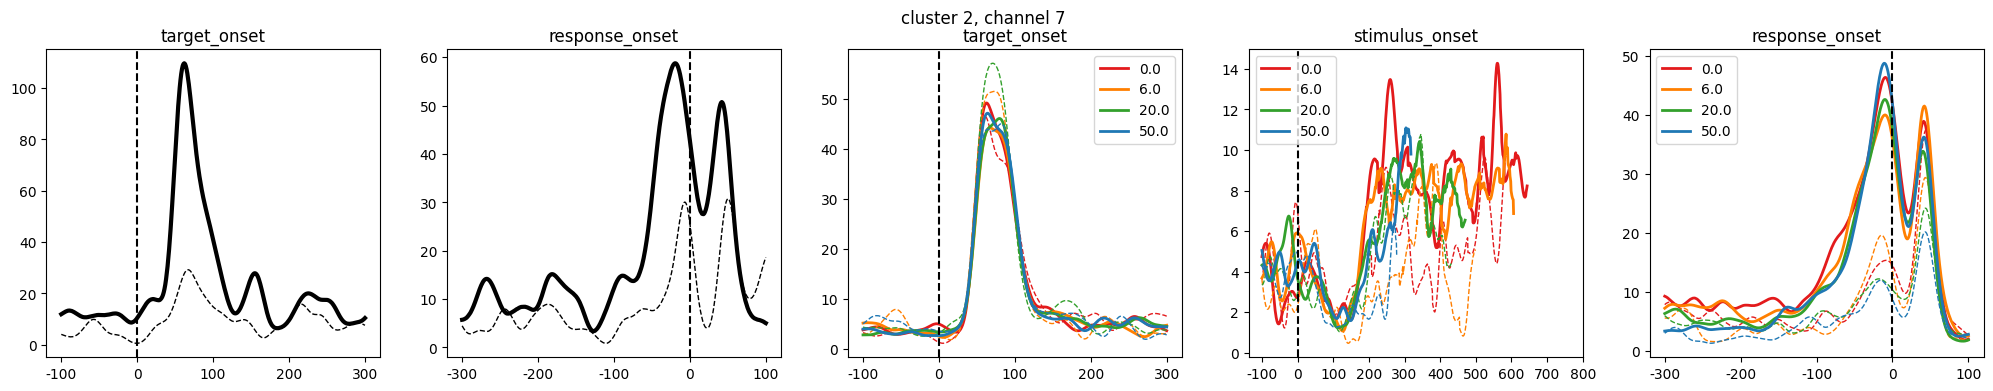

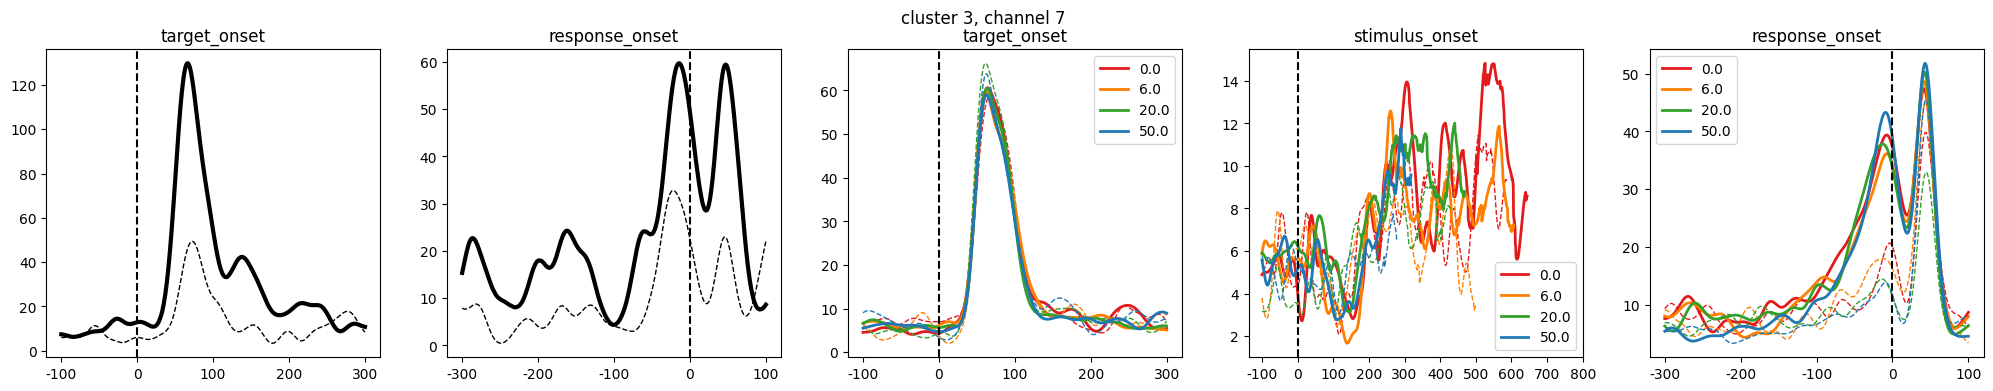

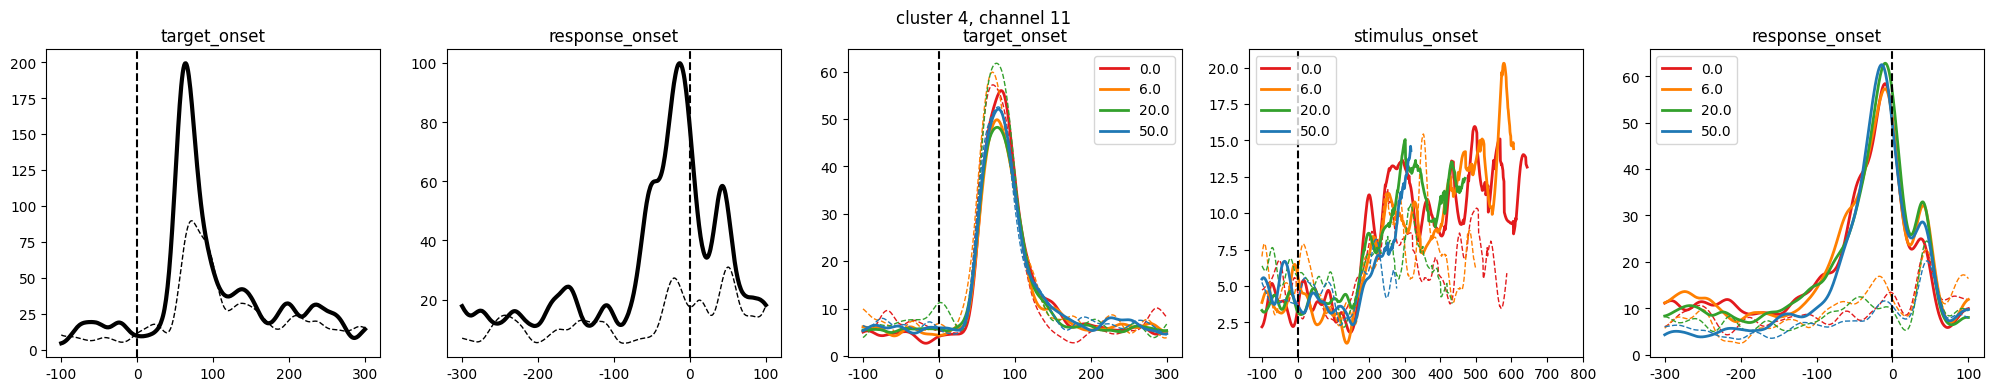

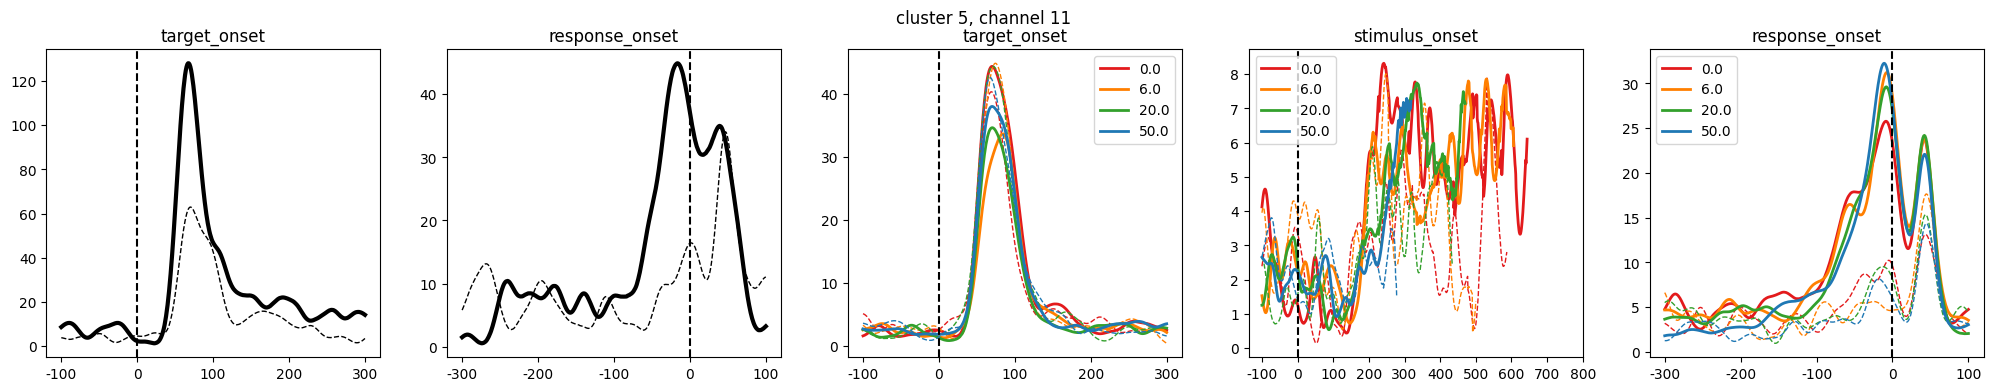

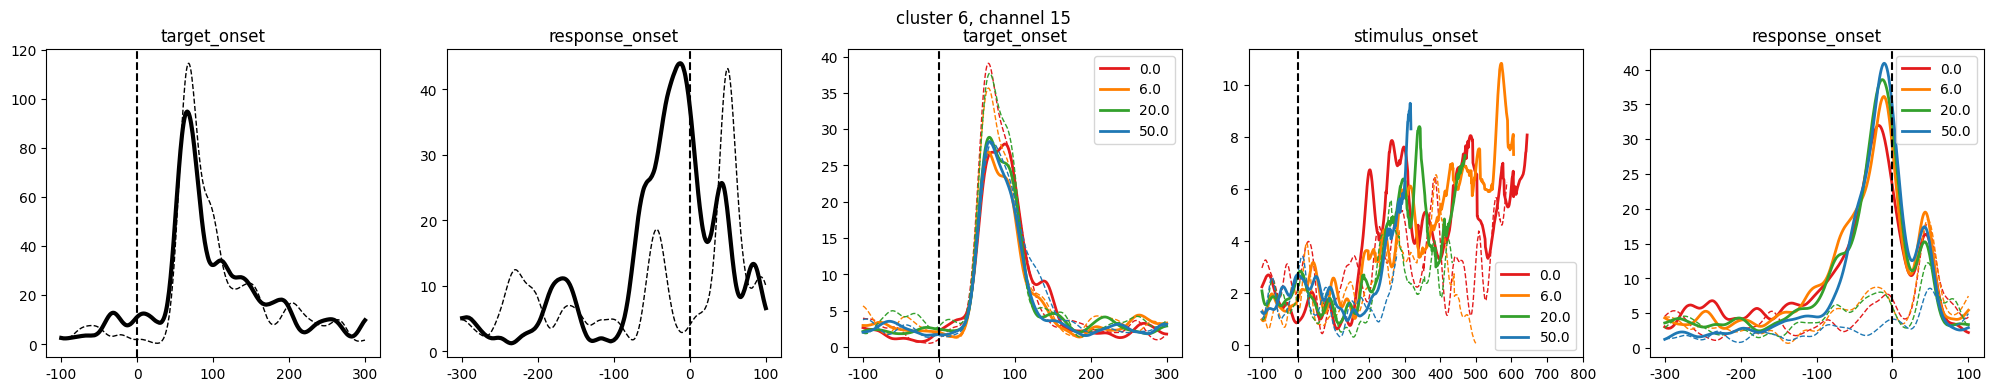

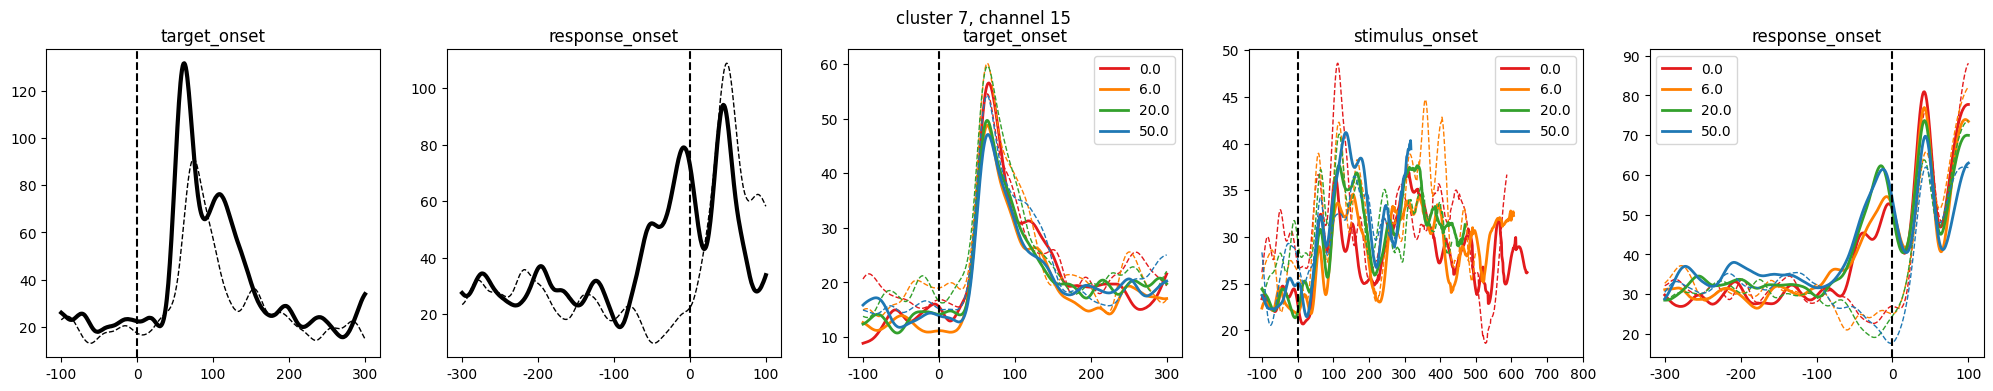

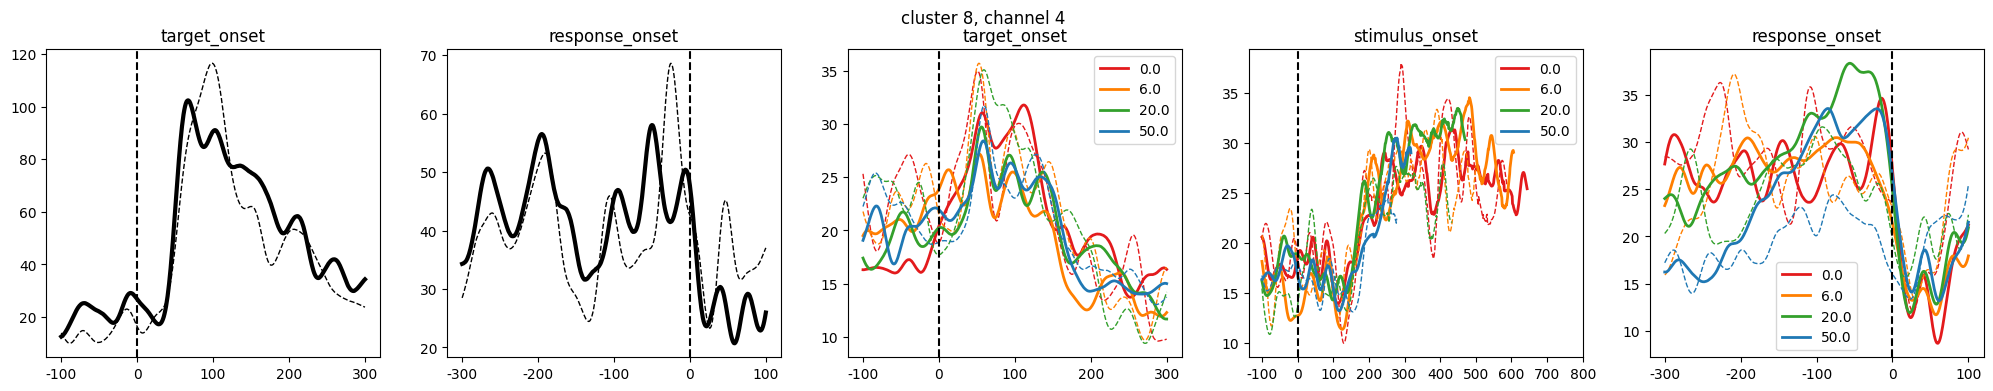

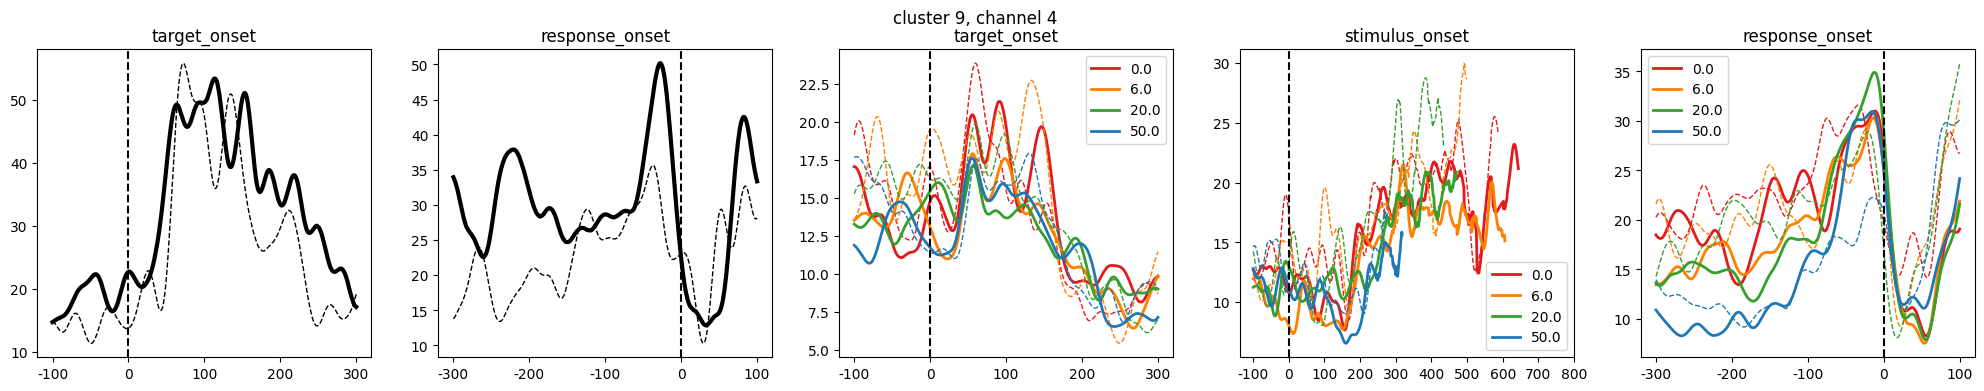

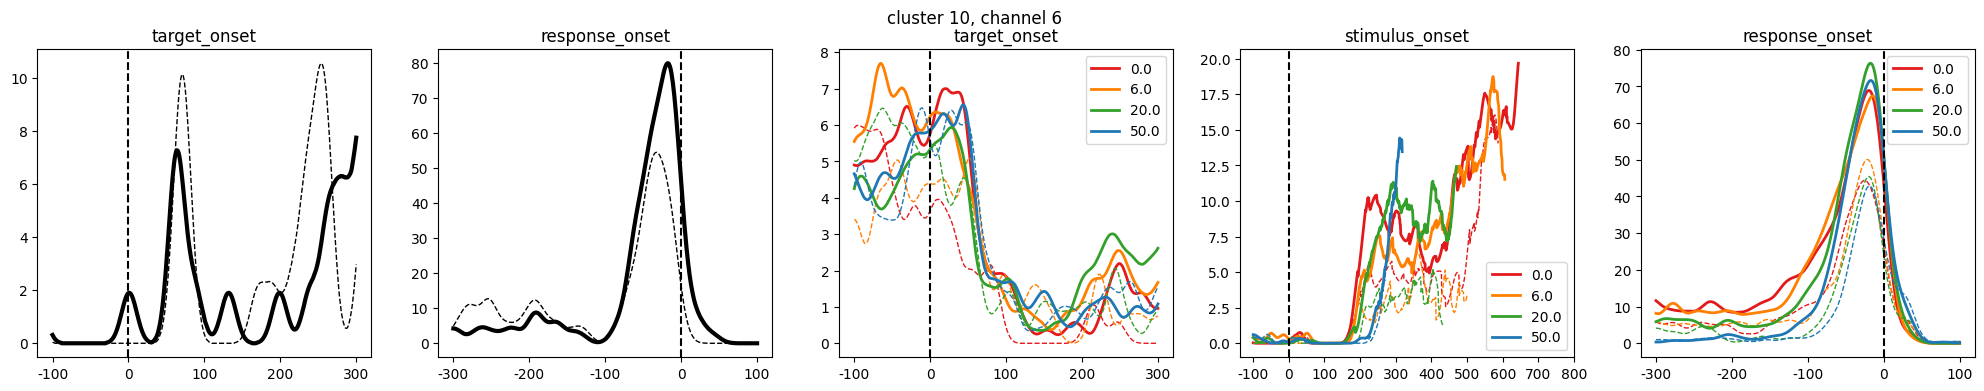

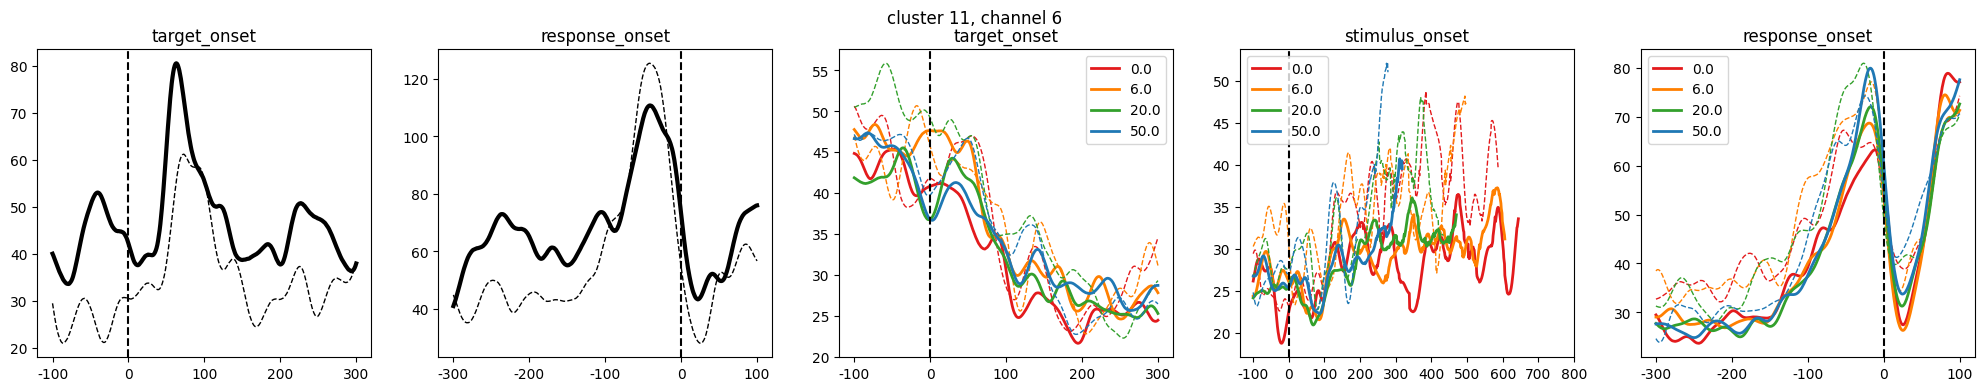

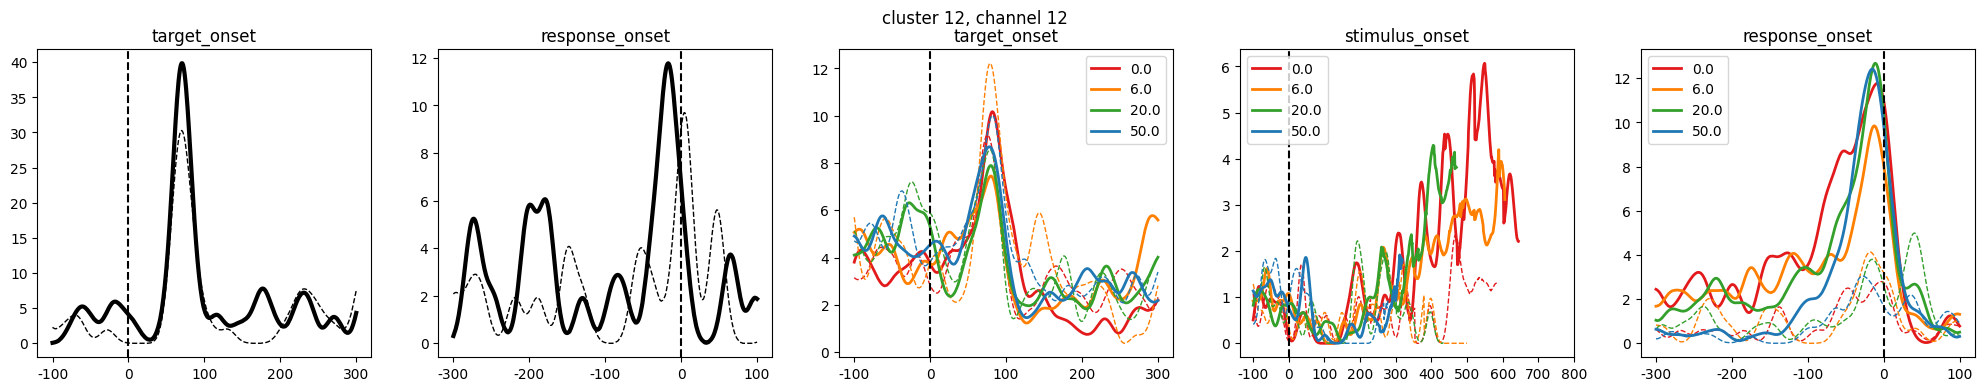

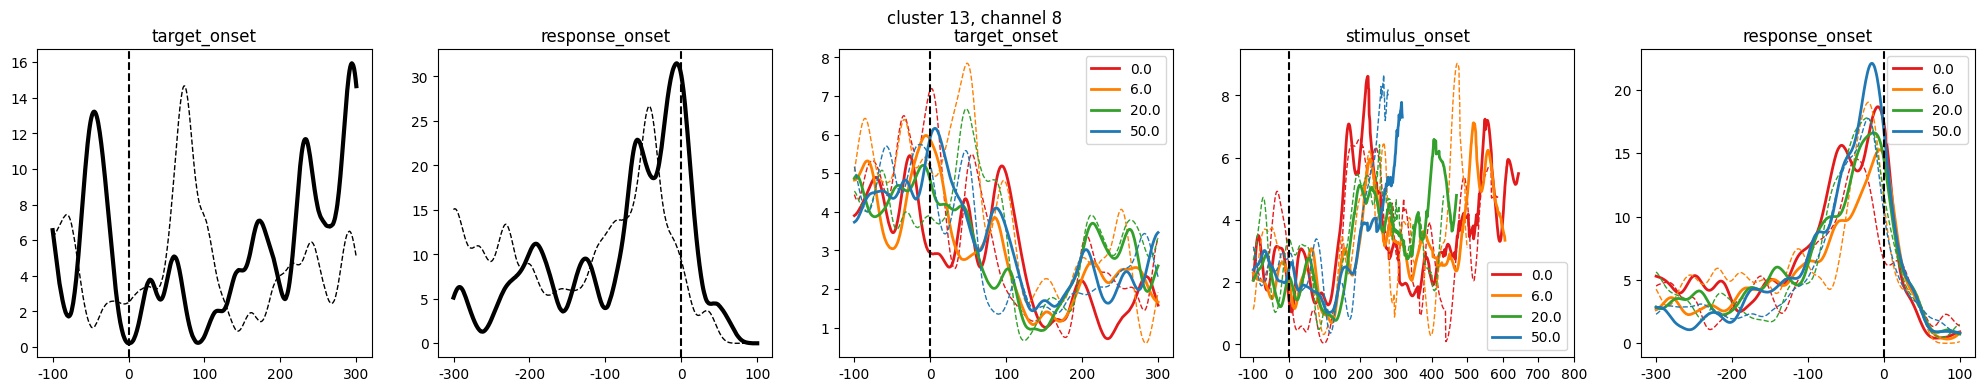

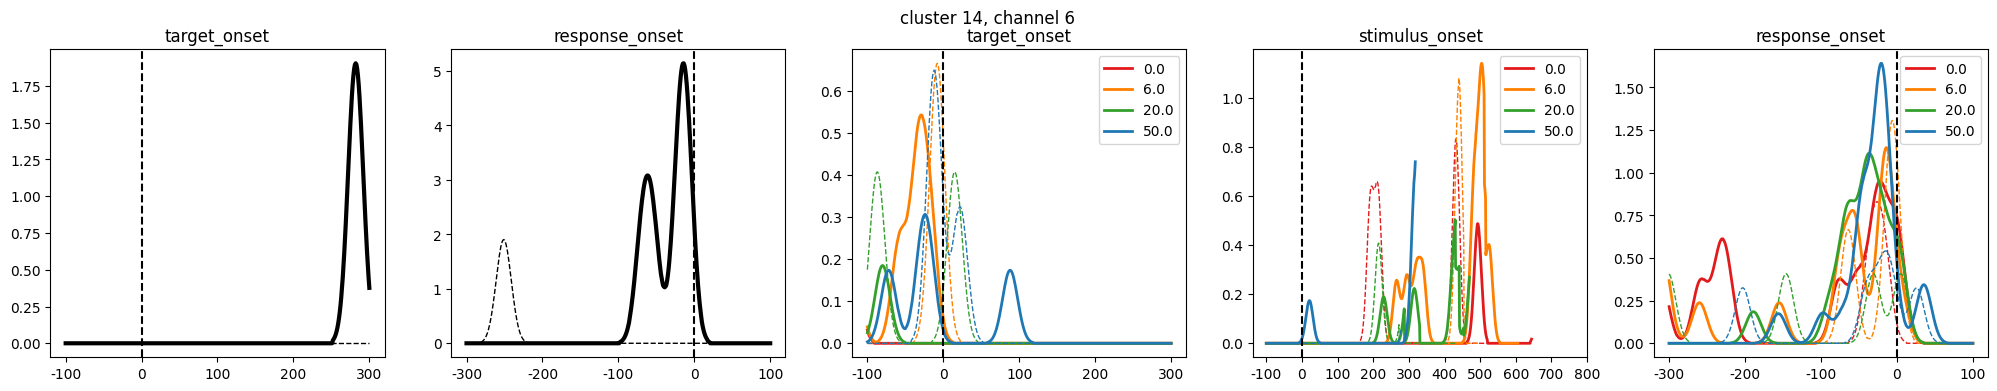

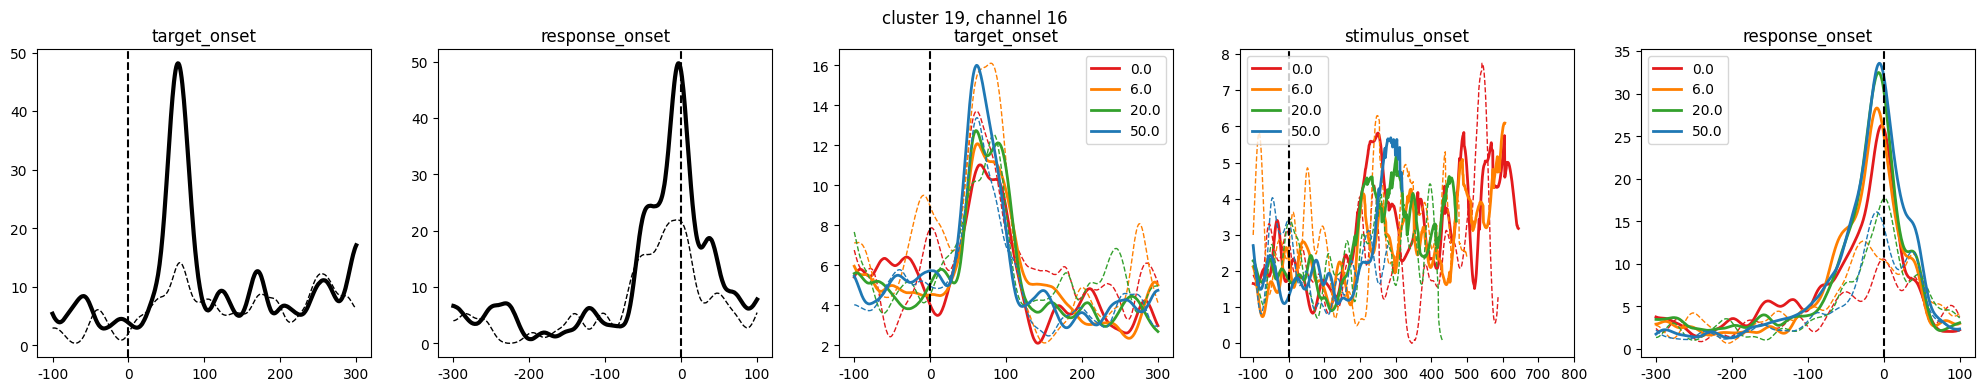

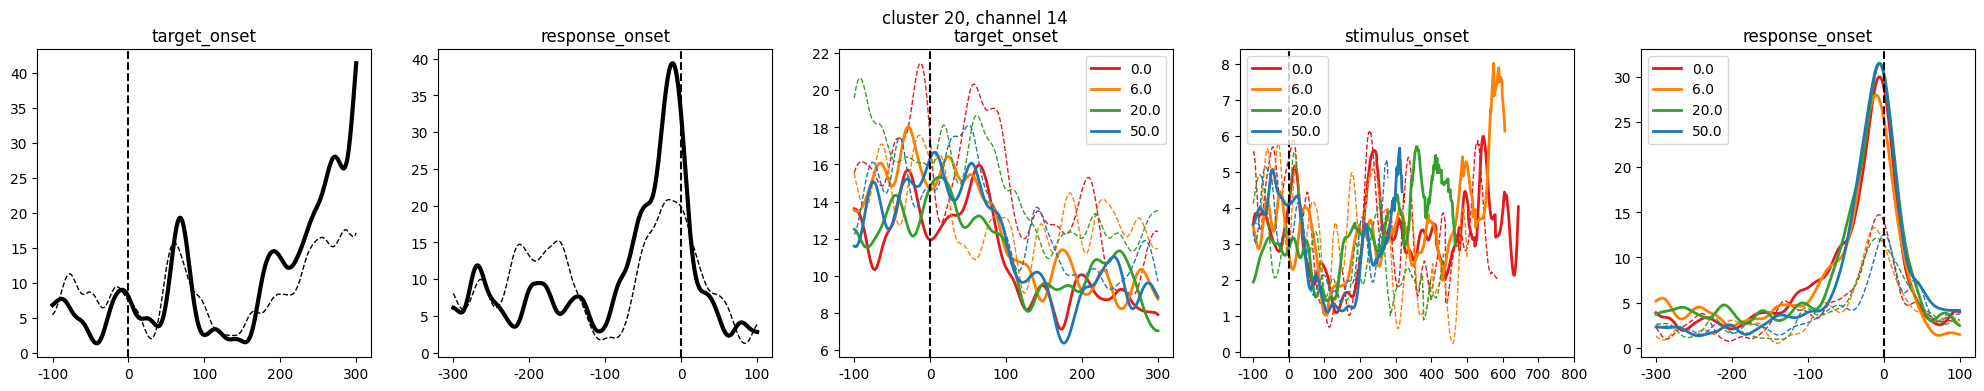

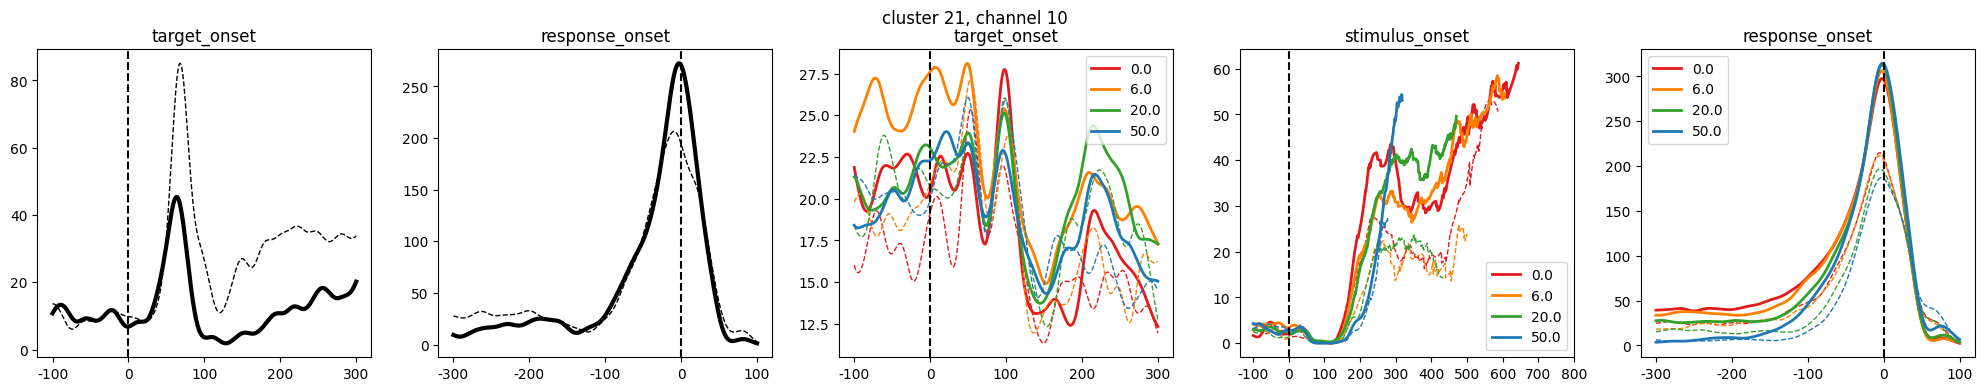

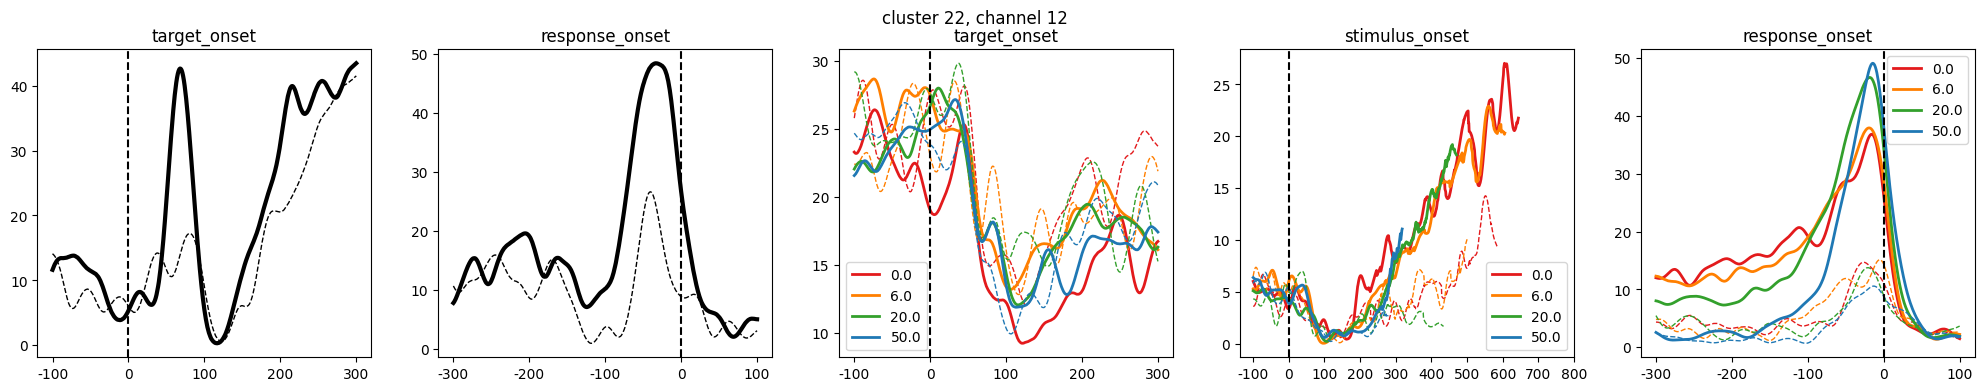

In [34]:
# extract spike times for one cluster/unit
colors = ['#e31a1c','#ff7f00','#33a02c','#1f78b4']

for cluster_id in cluster_to_show :
    cluster_spike_time = spike_times[spike_clusters == cluster_id]
    VGS_spike_train,VGS_convolved_spike_density = spike_train_convolved(cluster_spike_time,timestamps,VGS_valid_trial_idx,alignment_settings_VGS,alignment_buffer)
    GP_spike_train,GP_convolved_spike_density = spike_train_convolved(cluster_spike_time,timestamps,GP_valid_trial_idx,alignment_settings_GP,alignment_buffer)

    #separate toRF trials and awayRF trials
    toRF_VGS_trials = np.where(trial_info.loc[VGS_valid_trial_idx,'choice'] == 1)[0]
    awayRF_VGS_trials = np.where(trial_info.loc[VGS_valid_trial_idx,'choice'] == 0)[0]

    plt.figure(cluster_id+1, figsize =(25,4))
    plt.suptitle(f"cluster {cluster_id}, channel {1+cluster_info.loc[cluster_info['cluster_id'] == cluster_id,'ch'].item()}")
    for alignment_idx in range(len(alignment_settings_VGS)):
        plt.subplot(1,len(alignment_settings_VGS)+len(alignment_settings_GP),alignment_idx+1)
        plt.plot(VGS_convolved_spike_density[alignment_idx][toRF_VGS_trials,:].mean(axis=0),color = 'k',linewidth = 3)
        plt.plot(VGS_convolved_spike_density[alignment_idx][awayRF_VGS_trials,:].mean(axis=0),linestyle = '--',color = 'k',linewidth = 1)
        plt.title(alignment_settings_VGS[alignment_idx]['alignment_event'])
        plt.axvline(x = -alignment_settings_VGS[alignment_idx]['start_time_ms'],linestyle = '--',color = 'k')
        plt.xticks(np.arange(0,VGS_convolved_spike_density[alignment_idx].shape[1] , 100),labels = np.arange(alignment_settings_VGS[alignment_idx]['start_time_ms'],alignment_settings_VGS[alignment_idx]['end_time_ms']+1 , 100))



    #separate toRF/awayRF and different cohrence correcttrials
    toRF_GP_coh_trials = []
    awayRF_GP_coh_trials = []
    for coherence in coherence_levels:
        if coherence == 0:
            toRF_GP_coh_trials.append(np.where((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence))[0])
            awayRF_GP_coh_trials.append(np.where((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence))[0])
        else:
            toRF_GP_coh_trials.append(np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1))[0])
            awayRF_GP_coh_trials.append(np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 0) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1))[0])

  

    # plt.figure(cluster_id *2 + 2, figsize =(15,4))
    # plt.suptitle(cluster_id)
    for alignment_idx in range(len(alignment_settings_GP)):
        plt.subplot(1,len(alignment_settings_VGS)+len(alignment_settings_GP),alignment_idx+1+len(alignment_settings_VGS))
        for coh_idx in range(len(coherence_levels)):
            if alignment_settings_GP[alignment_idx]['alignment_event'] == 'stimulus_onset':
                toRF_reaction_time = np.nanmedian(trial_info.loc[GP_valid_trial_idx[toRF_GP_coh_trials[coh_idx]],'reaction_time'])
                toRF_end = np.min([toRF_reaction_time-50,alignment_settings_GP[alignment_idx]['end_time_ms']]).astype(int) - alignment_settings_GP[alignment_idx]['start_time_ms'] + 2
                awayRF_reaction_time = np.nanmedian(trial_info.loc[GP_valid_trial_idx[awayRF_GP_coh_trials[coh_idx]],'reaction_time'])
                awayRF_end = np.min([awayRF_reaction_time-50,alignment_settings_GP[alignment_idx]['end_time_ms']]).astype(int) - alignment_settings_GP[alignment_idx]['start_time_ms'] + 2
 
            else:
                toRF_end = alignment_settings_GP[alignment_idx]['end_time_ms'] - alignment_settings_GP[alignment_idx]['start_time_ms'] + 2
                awayRF_end = alignment_settings_GP[alignment_idx]['end_time_ms'] - alignment_settings_GP[alignment_idx]['start_time_ms'] + 2
                
            plt.plot(np.nanmean(GP_convolved_spike_density[alignment_idx][toRF_GP_coh_trials[coh_idx],:toRF_end],axis=0),color = colors[coh_idx],linewidth = 2,label = str(coherence_levels[coh_idx]))
            plt.plot(np.nanmean(GP_convolved_spike_density[alignment_idx][awayRF_GP_coh_trials[coh_idx],:awayRF_end],axis=0),linestyle = '--',color =  colors[coh_idx],linewidth = 1)

        plt.title(alignment_settings_GP[alignment_idx]['alignment_event'])
        plt.axvline(x = -alignment_settings_GP[alignment_idx]['start_time_ms'],linestyle = '--',color = 'k')
        plt.xticks(np.arange(0,GP_convolved_spike_density[alignment_idx].shape[1] , 100),labels = np.arange(alignment_settings_GP[alignment_idx]['start_time_ms'],alignment_settings_GP[alignment_idx]['end_time_ms']+1 , 100))
        plt.legend()



##### equal vs unequal prior trials

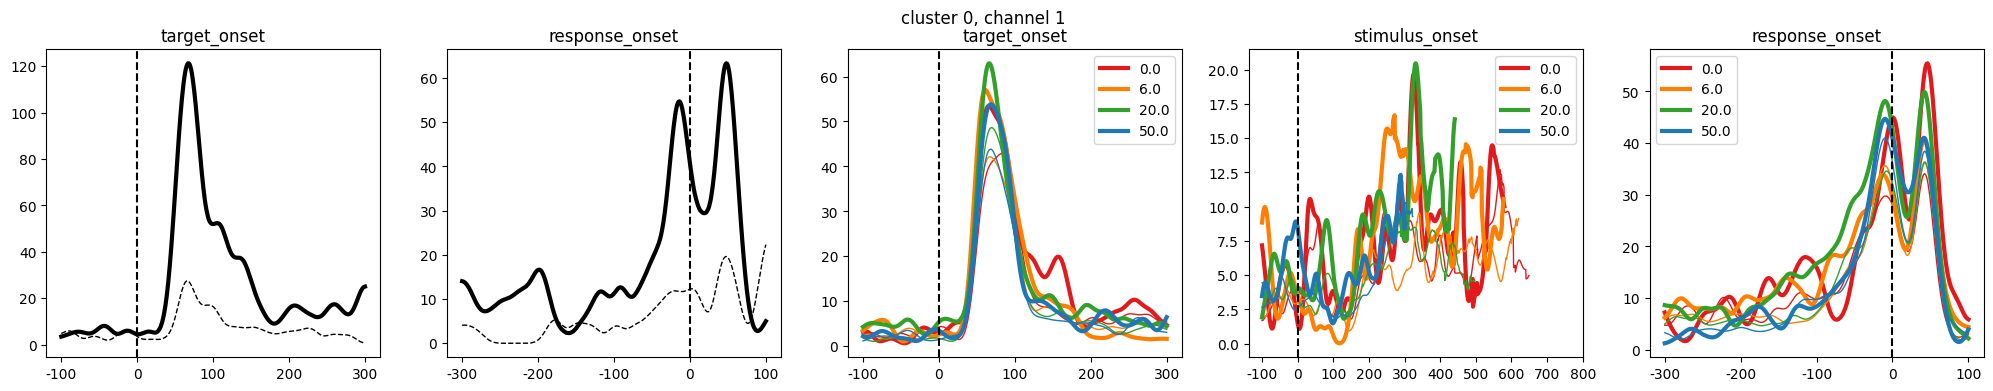

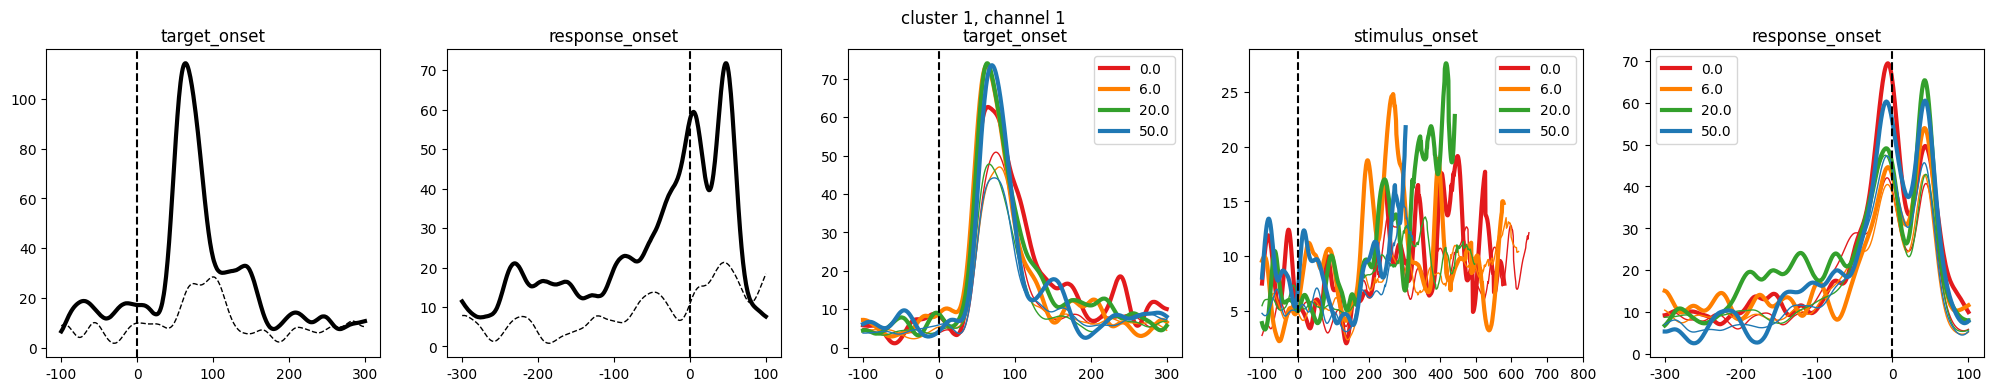

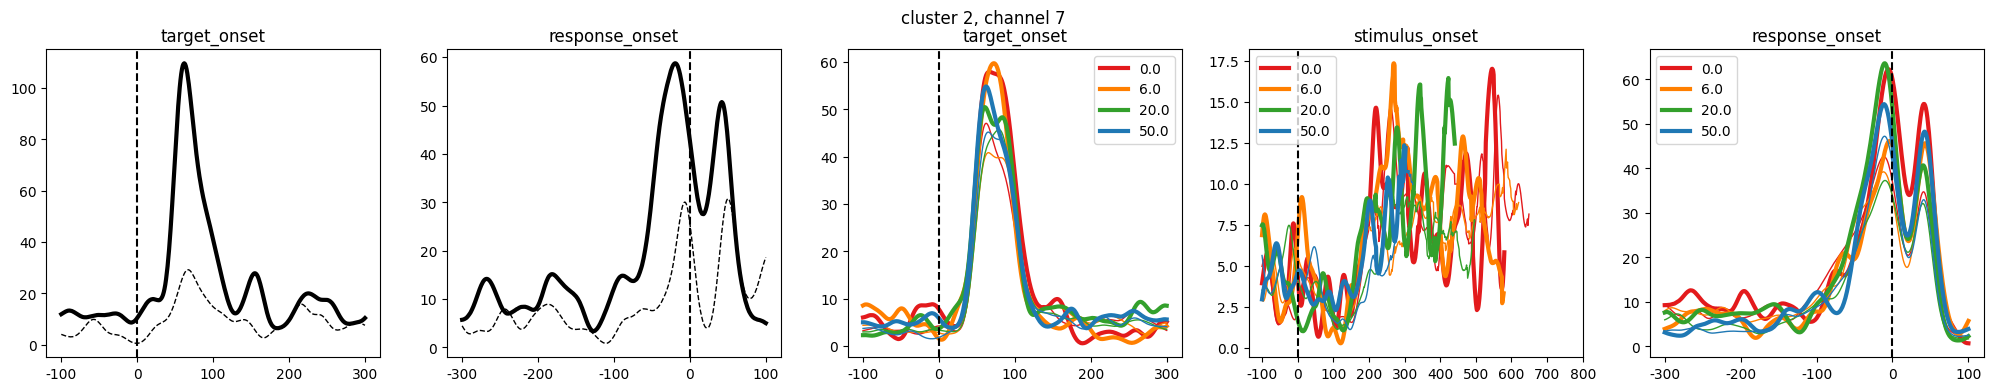

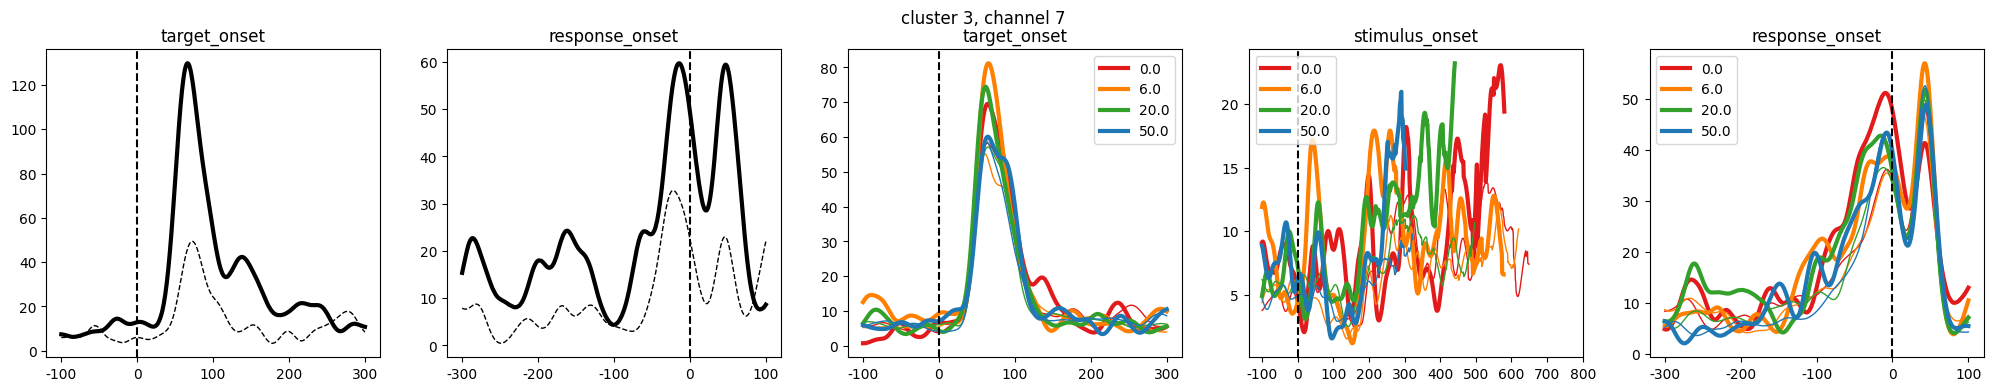

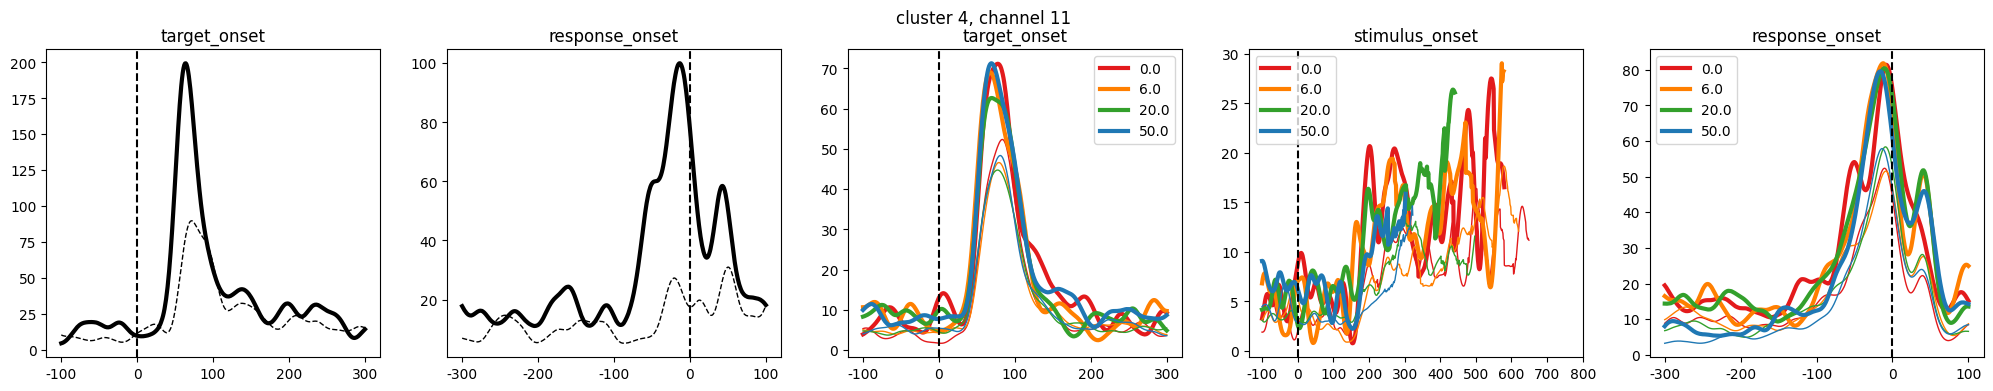

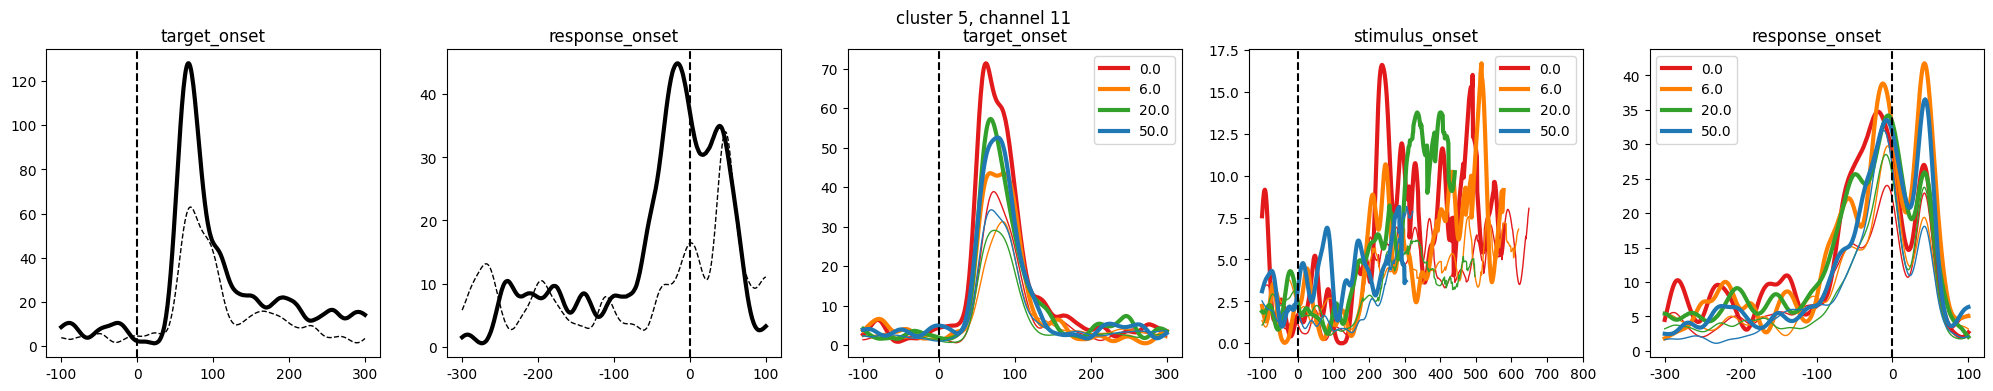

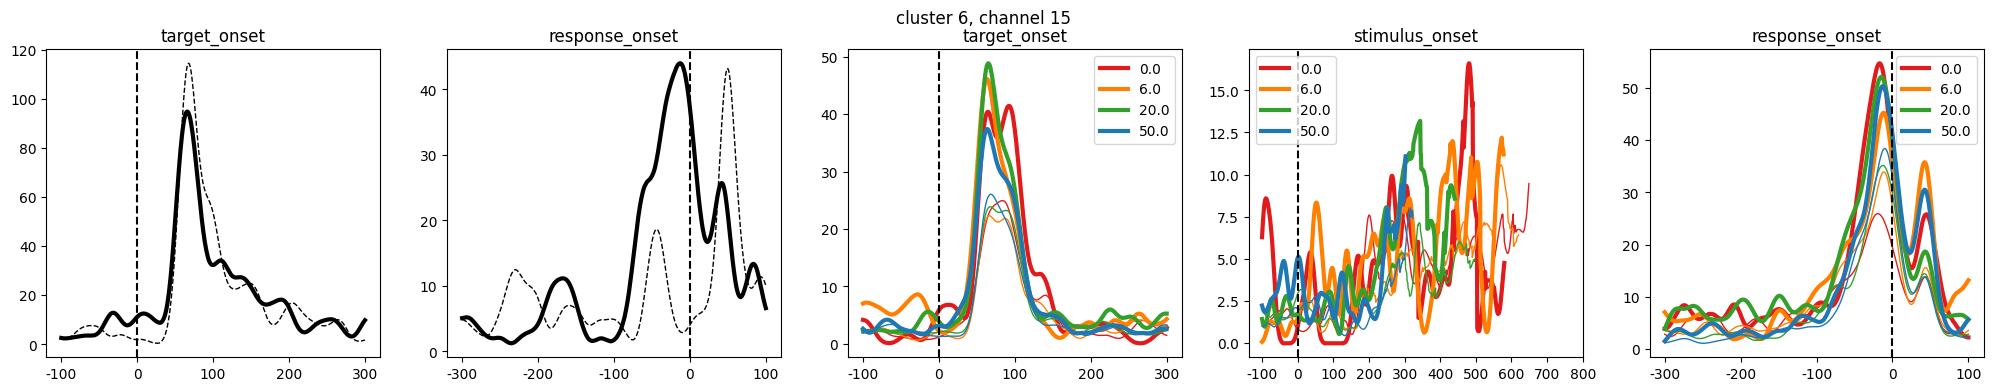

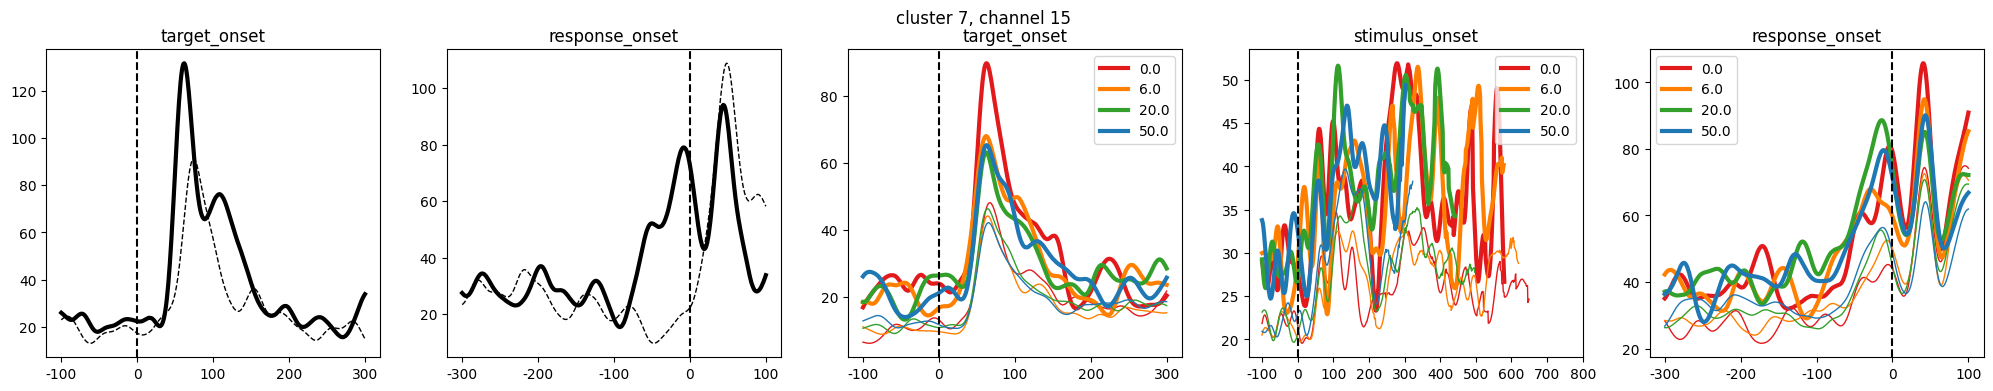

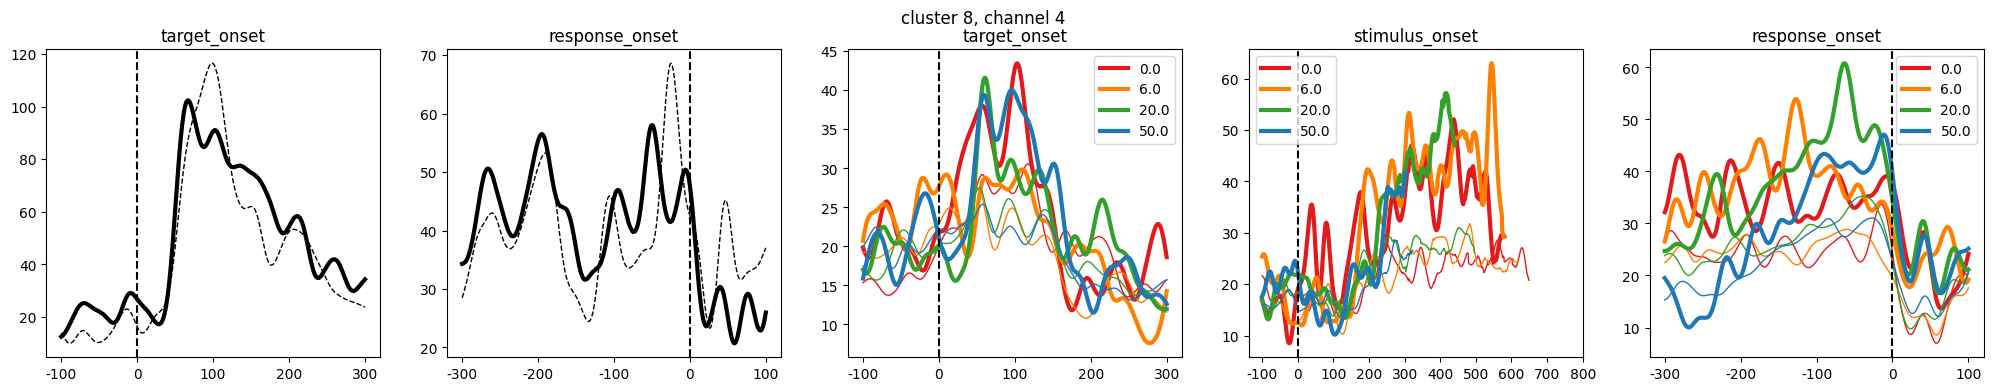

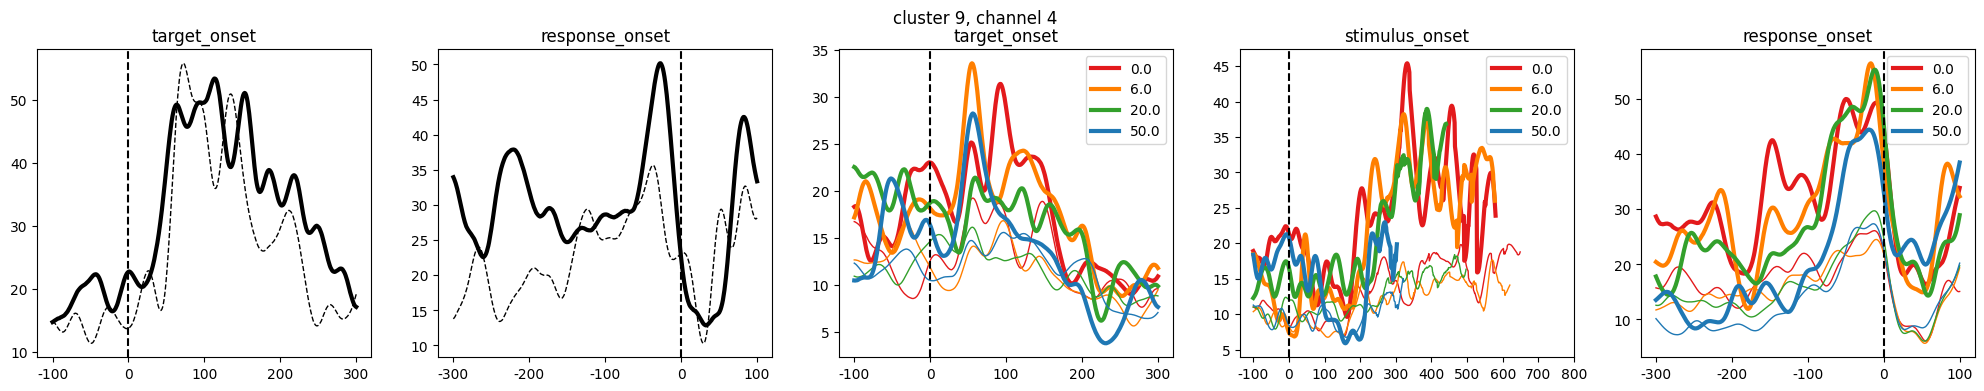

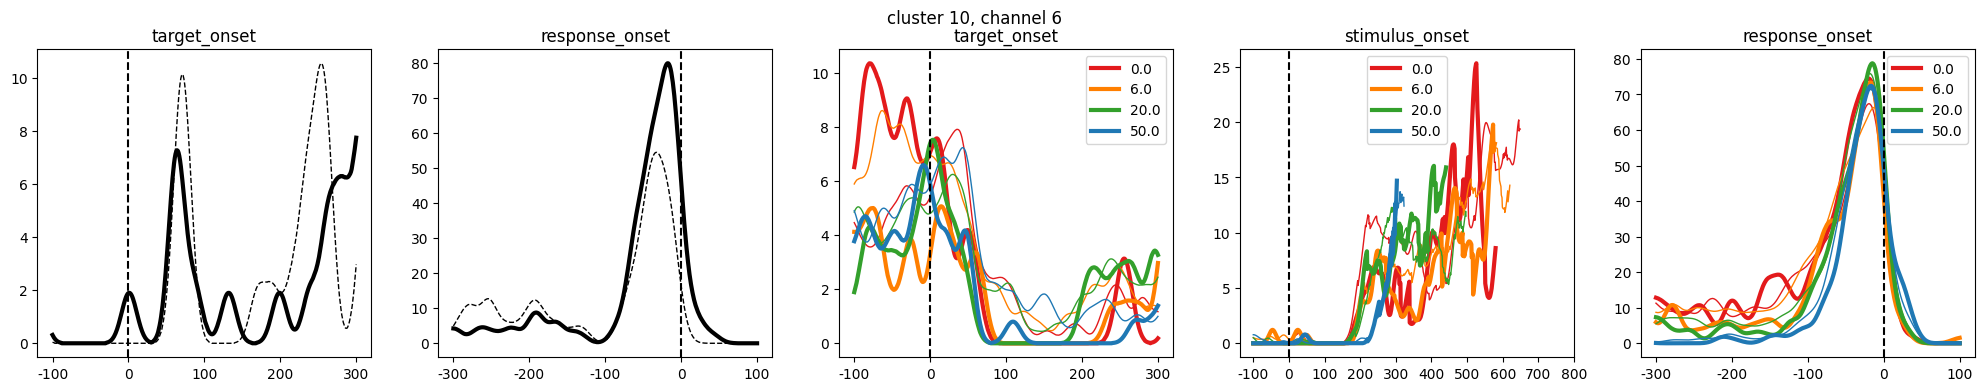

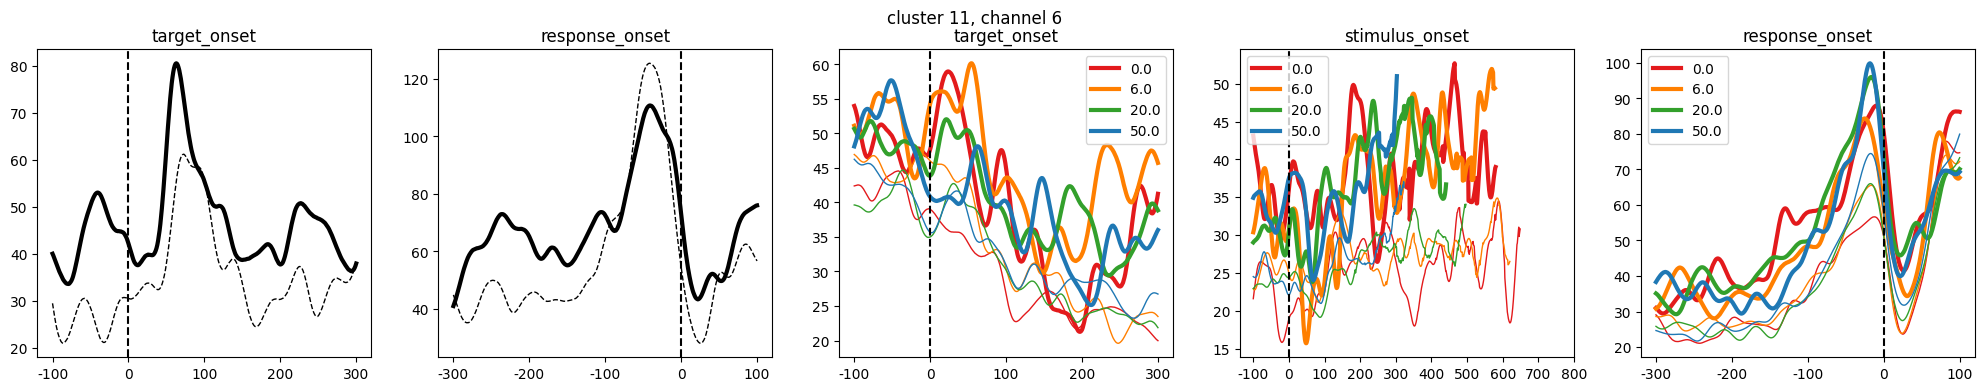

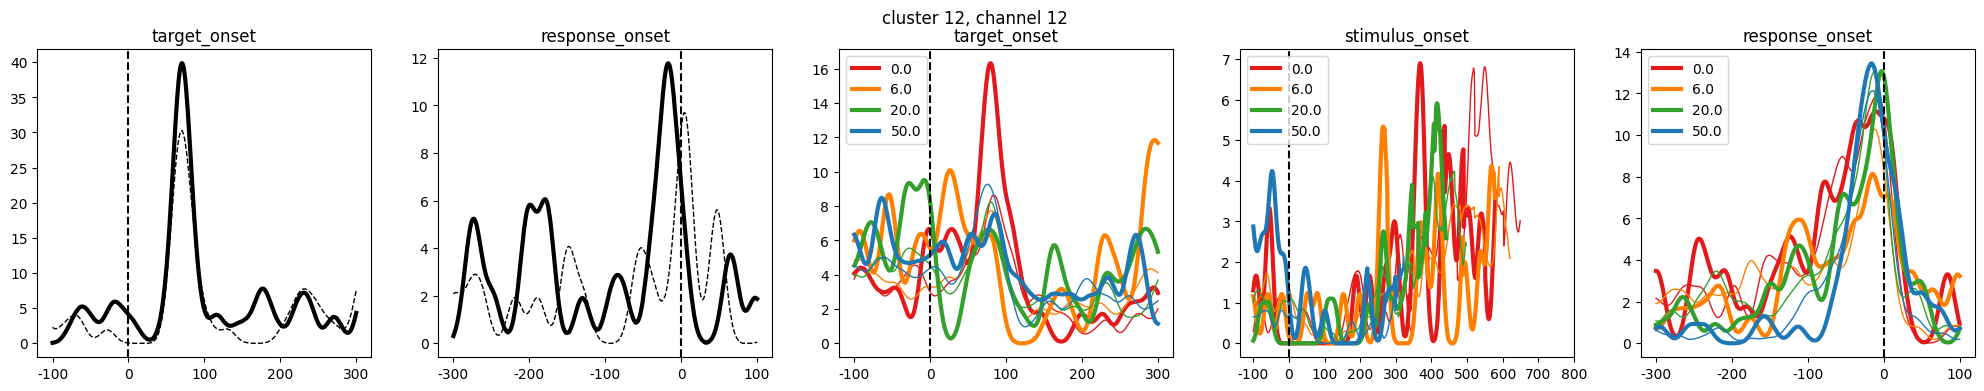

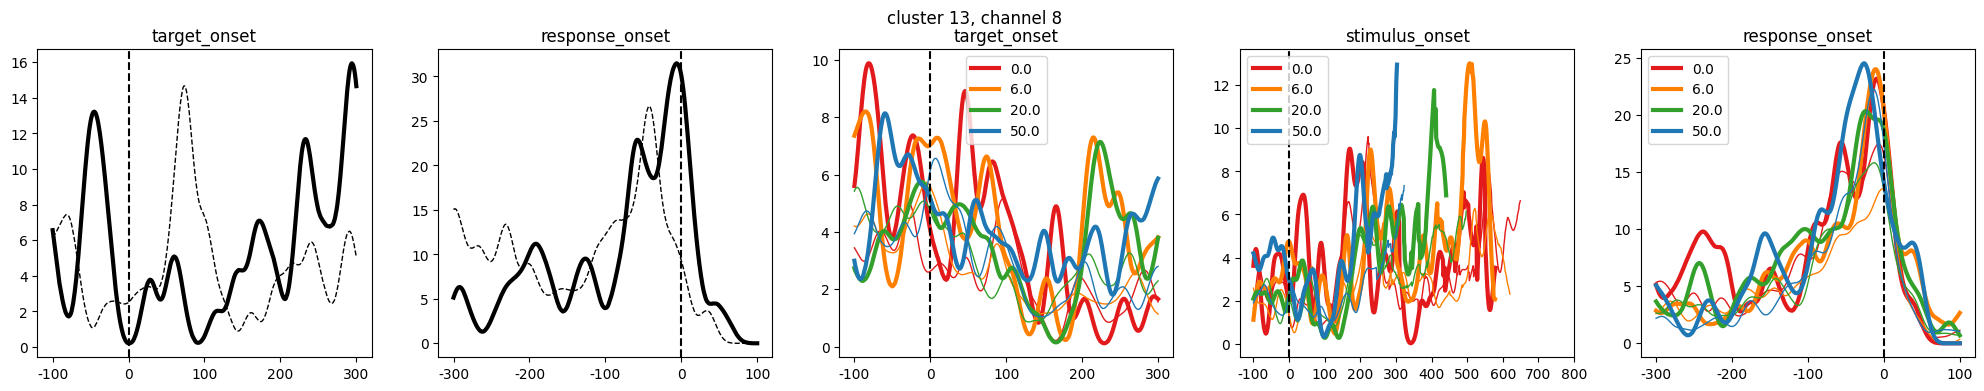

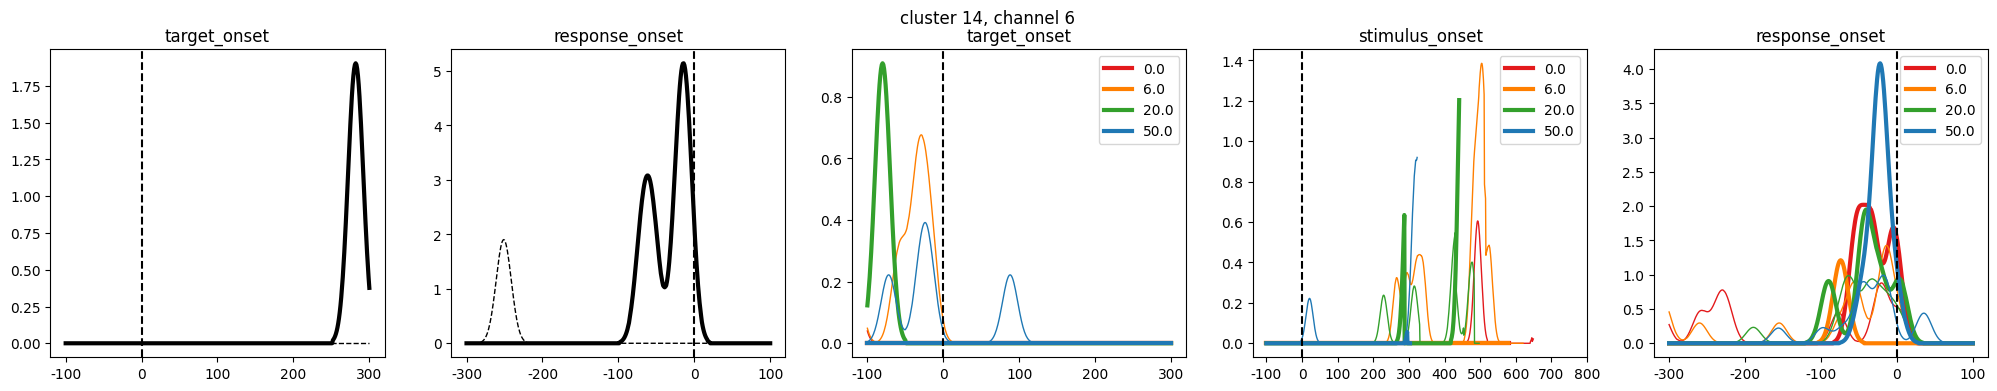

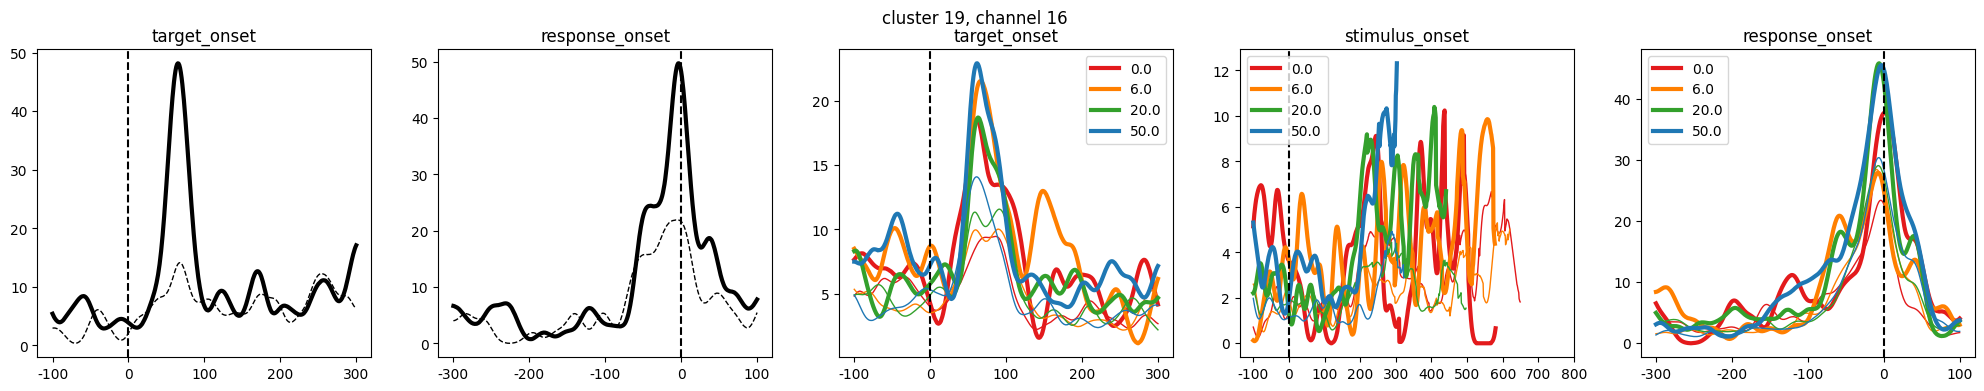

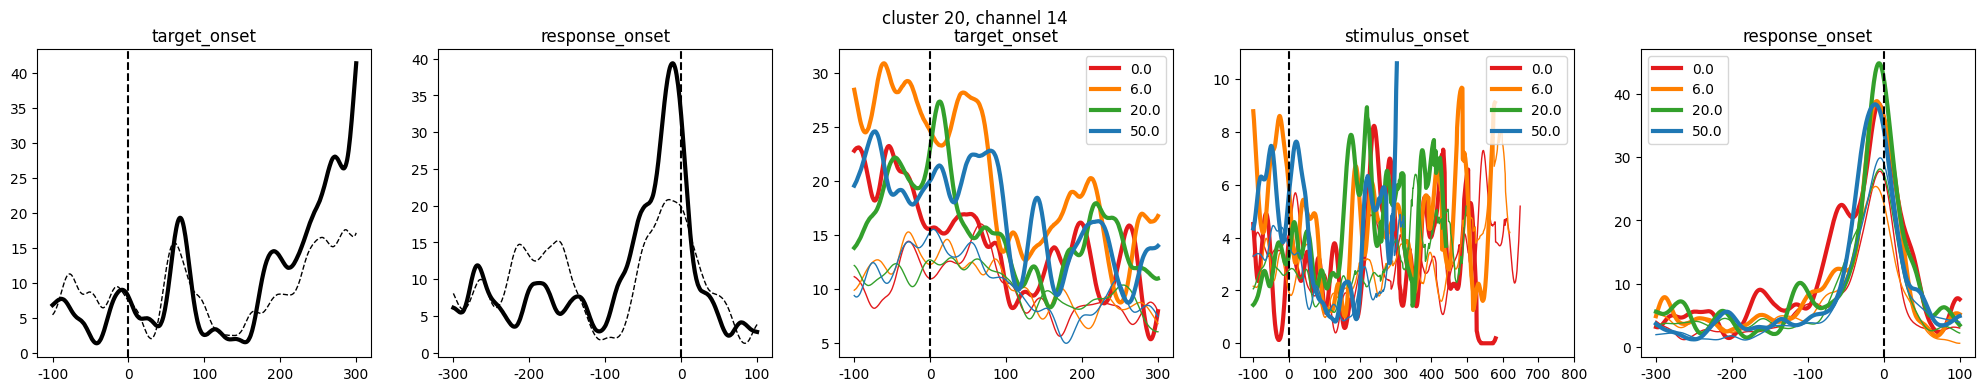

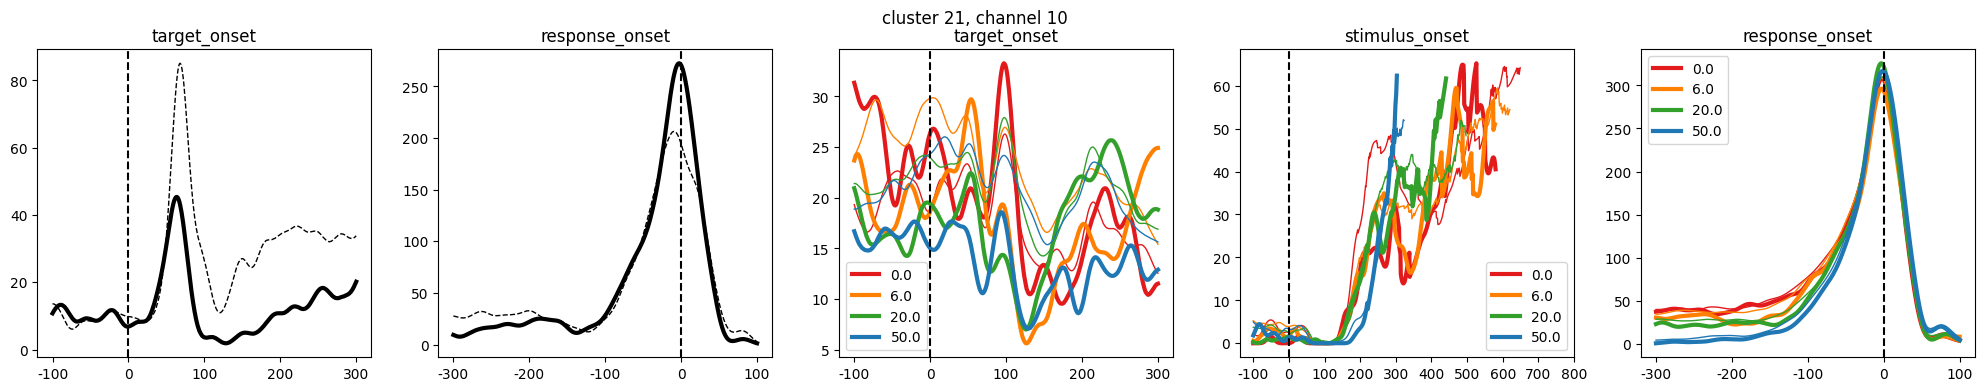

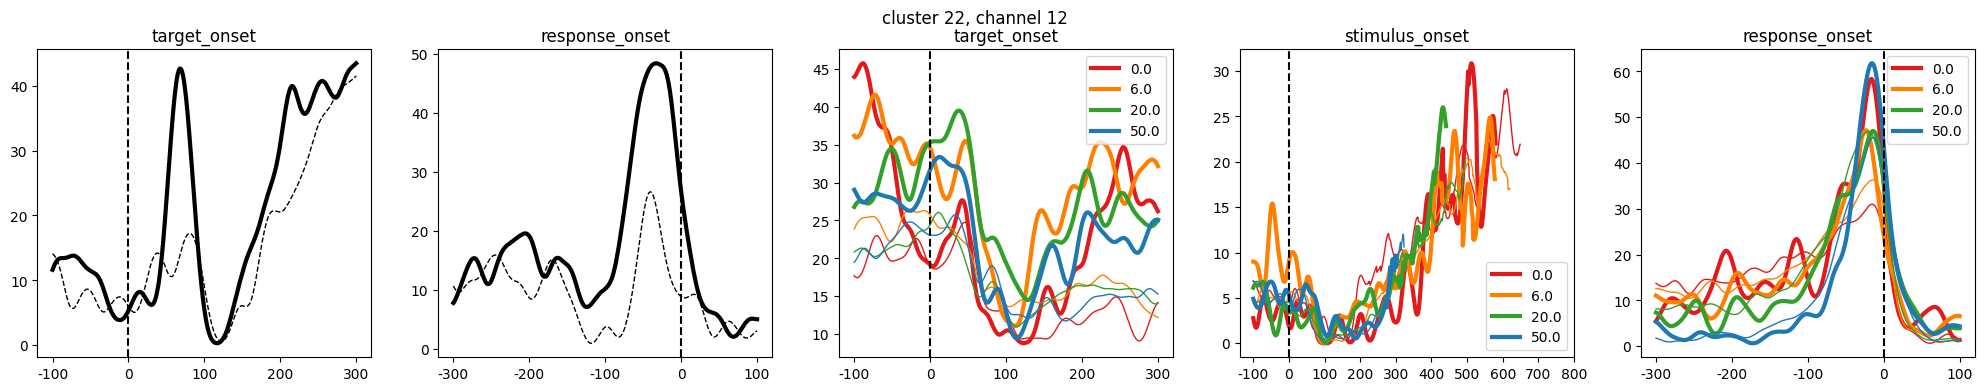

In [36]:
# extract spike times for one cluster/unit
colors = ['#e31a1c','#ff7f00','#33a02c','#1f78b4']

for cluster_id in cluster_to_show :
    cluster_spike_time = spike_times[spike_clusters == cluster_id]
    VGS_spike_train,VGS_convolved_spike_density = spike_train_convolved(cluster_spike_time,timestamps,VGS_valid_trial_idx,alignment_settings_VGS,alignment_buffer)
    GP_spike_train,GP_convolved_spike_density = spike_train_convolved(cluster_spike_time,timestamps,GP_valid_trial_idx,alignment_settings_GP,alignment_buffer)

    #separate toRF trials and awayRF trials
    toRF_VGS_trials = np.where(trial_info.loc[VGS_valid_trial_idx,'choice'] == 1)[0]
    awayRF_VGS_trials = np.where(trial_info.loc[VGS_valid_trial_idx,'choice'] == 0)[0]

    plt.figure(cluster_id+1, figsize =(25,4))
    plt.suptitle(f"cluster {cluster_id}, channel {1+cluster_info.loc[cluster_info['cluster_id'] == cluster_id,'ch'].item()}")
    for alignment_idx in range(len(alignment_settings_VGS)):
        plt.subplot(1,len(alignment_settings_VGS)+len(alignment_settings_GP),alignment_idx+1)
        plt.plot(VGS_convolved_spike_density[alignment_idx][toRF_VGS_trials,:].mean(axis=0),color = 'k',linewidth = 3)
        plt.plot(VGS_convolved_spike_density[alignment_idx][awayRF_VGS_trials,:].mean(axis=0),linestyle = '--',color = 'k',linewidth = 1)
        plt.title(alignment_settings_VGS[alignment_idx]['alignment_event'])
        plt.axvline(x = -alignment_settings_VGS[alignment_idx]['start_time_ms'],linestyle = '--',color = 'k')
        plt.xticks(np.arange(0,VGS_convolved_spike_density[alignment_idx].shape[1] , 100),labels = np.arange(alignment_settings_VGS[alignment_idx]['start_time_ms'],alignment_settings_VGS[alignment_idx]['end_time_ms']+1 , 100))



    #separate baseline/prior and different cohrence correct toRF trials
    equal_GP_coh_trials = []
    unequal_GP_coh_trials = []
    for coherence in coherence_levels:
        if coherence == 0:
            equal_GP_coh_trials.append(np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0])
            unequal_GP_coh_trials.append(np.where(((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0])
        else:
            equal_GP_coh_trials.append(np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] == 50))[0])
            unequal_GP_coh_trials.append(np.where((((trial_info.loc[GP_valid_trial_idx,'choice'] == 1) & (trial_info.loc[GP_valid_trial_idx,'coherence'] == coherence)) & (trial_info.loc[GP_valid_trial_idx,'outcome'] == 1)) & (trial_info.loc[GP_valid_trial_idx,'prob_toRF'] != 50))[0])

  

    # plt.figure(cluster_id *2 + 2, figsize =(15,4))
    # plt.suptitle(cluster_id)
    for alignment_idx in range(len(alignment_settings_GP)):
        plt.subplot(1,len(alignment_settings_VGS)+len(alignment_settings_GP),alignment_idx+1+len(alignment_settings_VGS))
        for coh_idx in range(len(coherence_levels)):
            if alignment_settings_GP[alignment_idx]['alignment_event'] == 'stimulus_onset':
                equal_reaction_time = np.nanmedian(trial_info.loc[GP_valid_trial_idx[equal_GP_coh_trials[coh_idx]],'reaction_time'])
                equal_end = np.min([equal_reaction_time-50,alignment_settings_GP[alignment_idx]['end_time_ms']]).astype(int) - alignment_settings_GP[alignment_idx]['start_time_ms'] + 2
                unequal_reaction_time = np.nanmedian(trial_info.loc[GP_valid_trial_idx[unequal_GP_coh_trials[coh_idx]],'reaction_time'])
                unequal_end = np.min([unequal_reaction_time-50,alignment_settings_GP[alignment_idx]['end_time_ms']]).astype(int) - alignment_settings_GP[alignment_idx]['start_time_ms'] + 2
 
            else:
                equal_end = alignment_settings_GP[alignment_idx]['end_time_ms'] - alignment_settings_GP[alignment_idx]['start_time_ms'] + 2
                unequal_end = alignment_settings_GP[alignment_idx]['end_time_ms'] - alignment_settings_GP[alignment_idx]['start_time_ms'] + 2
                
            plt.plot(np.nanmean(GP_convolved_spike_density[alignment_idx][equal_GP_coh_trials[coh_idx],:equal_end],axis=0),color = colors[coh_idx],linewidth = 3,label = str(coherence_levels[coh_idx]))
            plt.plot(np.nanmean(GP_convolved_spike_density[alignment_idx][unequal_GP_coh_trials[coh_idx],:unequal_end],axis=0),color =  colors[coh_idx],linewidth = 1)

        plt.title(alignment_settings_GP[alignment_idx]['alignment_event'])
        plt.axvline(x = -alignment_settings_GP[alignment_idx]['start_time_ms'],linestyle = '--',color = 'k')
        plt.xticks(np.arange(0,GP_convolved_spike_density[alignment_idx].shape[1] , 100),labels = np.arange(alignment_settings_GP[alignment_idx]['start_time_ms'],alignment_settings_GP[alignment_idx]['end_time_ms']+1 , 100))
        plt.legend()

